# **Normalisation Training Colab**

This Colab serves for training "LSTM_with_norm" models' normalisation parameters from pre-trained models (found in reports).

The following google drive link corresponds to the most recent project folder(you'll need to ask for access):
https://drive.google.com/drive/folders/1iZtHF_jrLXeIBbAIk5AXBtS-5Ib6sCQ7?usp=sharing

The following cell includes the bare minimum to mount google drive to google colab so that the files can be directly called. The `folder_name` may have to be updated to the latest `Battery_SOH` folder.

In [ ]:
from google.colab import drive
import os
import torch as th

# Mounting google drive
drive.mount('/content/gdrive')
folder_name = 'Battery_SOH_final'
# The root path will change depending on the latest 'bakcup'
root_path = 'gdrive/My Drive/battery_soh/' + folder_name
os.chdir(root_path)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
device

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


device(type='cuda', index=0)

The cell should output something like:
```
Mounted at /content/gdrive
device(type='cuda', index=0)
```

If the second line says `device(type='cpu')` then you should change your environment options above for GPU for faster results.

In [ ]:
# Imports:
# Libraries:
!pip install PyAstronomy
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import re
import random
import seaborn as sns
sns.set()

# SOH Modules:
# Battery Classes:
from Coin_Classes import *
from MIT_Classes import *
from Nasa_Classes import *
# Models:
from LSTM import *
import LSTM_with_norm as wn #
# Training and Report related:
from Training import *
from Load_Save import *
import DistributionPlots as dp

In [ ]:
# Useful dictionaries:
import main

dataset_path_dict = main.path_dict

# Batteries to exclude from training and validation datasets:
ignore_dict = {
    'NASA': ['B0049.txt', 'B0050.txt', 'B0051.txt', 'B0052.txt'],
    'MIT': ['B'+str(i).zfill(4)+'.txt' for i in range(15, 48)], 
    # There are no problems with these ^ batteries, it's just that MIT's dataset
    # is huge, so I don't include all of the batteries in the validation dataset
    'Tarascon Coin': ['B0008.txt', 'B0019.txt', 'B0023.txt'],
}

# Batteries to include in the training dataset:
train_dict = {
    'NASA': ['B0006.txt',
             'B0030.txt',
             'B0038.txt',
             'B0039.txt',
             'B0041.txt',
             'B0045.txt',
             'B0055.txt',], # 4ºC
    'MIT': ['B0001.txt'],
    'Tarascon Coin': ['B0001.txt',
                      'B0004.txt',
                      'B0014.txt',
                      'B0016.txt']
}

In [ ]:
### Pick the base report:
report_name = '2021-08-06 09_22_32.468552-nasav4'### (LSTM_v4 trained with NASA)

# getting the model from the report:
os.chdir('.//Reports/'+report_name)
with open('best_model.txt', 'rb') as f:
    base_model = pickle.load(f)
os.chdir('../../')

# Setting up a base model from LSTM_with_norm (wn)
if base_model.version in [1,2,3]:
    Model = wn.LSTM_v1(10, 10)
elif base_model.version in [4,5]:
    Model = wn.LSTM_v4(10, 10)
else:
    raise NameError("Invalid version: ", str(base_model.version))

# Copying the report's model's parameters
Model.from_model(base_model)
Model = Model.to(device)

In [ ]:
# initializing dataset related variables:
DELTA = base_model.delta
LSTM_version = base_model.version
norm_type = base_model.norm[4]

fixed_len = 150         ## Recommended values
time_step = None        ##
batch_size = 1          ##
adimensionalize=True    ##

cycle_lim = 1e6                     ### depends on your analysis
dataset_name = 'MIT'      ### NASA; MIT; Tarascon Coin.

In [ ]:
# Dataset creation:
try:
    os.chdir(dataset_path_dict[dataset_name])
except:
    raise FileNotFoundError("Current directory: ", os.getcwd())

files = os.listdir()    # All files in the folder
file_list = []          # List with the valid files

for file_name in files:
    match = re.search(r'B\d{4}.txt', file_name) # Only take into acount
                                                # the battery files
    if match == None:
        continue
    else:
        file_list.append(file_name)
file_list.sort()


ignore = ignore_dict[dataset_name]
train = train_dict[dataset_name]

# Training files:
Train_list = []
for file_name in file_list:
    if file_name not in train:
        continue
    else:
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)

        Train_list.append(Battery)

# Validation files:
Valid_list = []
for file_name in file_list:
    if (file_name not in train) and (file_name not in ignore):
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)
        Valid_list.append(Battery)

os.chdir('../../../../')

# wn datasets:
train_dataset = wn.Torch_Dataset_LSTM(
    Train_list, DELTA, LSTM_version, print_bool=True, time_step=time_step, 
    fixed_len=fixed_len, norm_type=norm_type, adimensionalize=adimensionalize,
    cycle_lim=cycle_lim
    )

valid_dataset = wn.Torch_Dataset_LSTM(
    Valid_list, DELTA, LSTM_version, print_bool=True,
    time_step=train_dataset.time_step, norm=train_dataset.norm,
    # time_step and norm are carried from the training dataset
    fixed_len=fixed_len, adimensionalize=adimensionalize, cycle_lim=cycle_lim
    )


# Loaders:
if train_dataset.fixed_len is None:
    train_loader = DataLoader(dataset=train_dataset, batch_size=1,
                                shuffle=True, num_workers=0)
    sim_train_loader = DataLoader(dataset=train_dataset, batch_size=1, 
                                  shuffle=False)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1,
                                shuffle=False, num_workers=0)
else:
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
    sim_train_loader = DataLoader(dataset=train_dataset, 
                                  batch_size=len(train_dataset), shuffle=False)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset),
                              shuffle=False, num_workers=0)

2.6253445148468018
B0001
130
B0000
B0002
B0003
B0004
B0005
B0006
B0007
B0008
B0009
B0010
B0011
B0012
B0013
B0014
7028


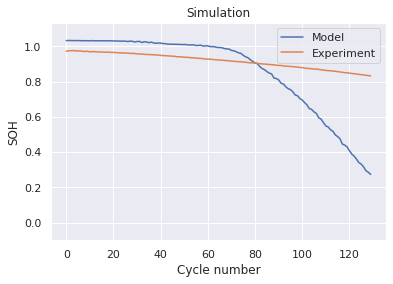

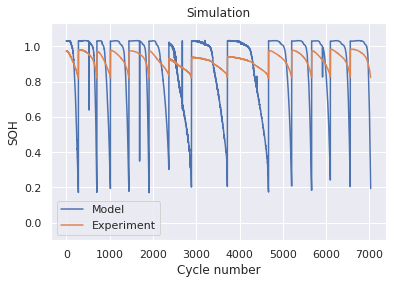

In [ ]:
# Preview of the model's performance as is:

simulate(sim_train_loader, Model, device=device, denormalize=False, report=True)
simulate(valid_loader, Model, device=device, denormalize=False, report=True)
# denormalize = False is important because normalization is done by the model
# since we are using wn models.

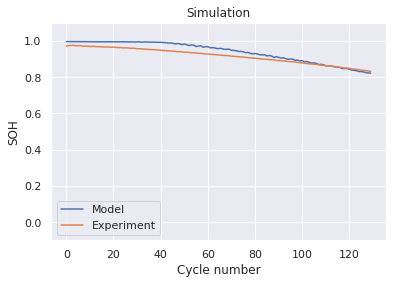

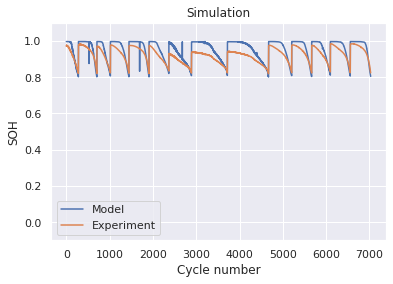

In [ ]:
# Now changing the model's norm to the dataset's:
Model.change_norm(train_dataset.norm)
Model = Model.to(device)    # just to make sure

# Evaluating it's performance now:
simulate(sim_train_loader, Model, device=device, denormalize=False, report=True)
simulate(valid_loader, Model, device=device, denormalize=False, report=True)

1 . Training loss:  tensor(0.0007)
1 . Validation loss:  tensor(0.0012)
2 . Training loss:  tensor(0.0006)
2 . Validation loss:  tensor(0.0010)
3 . Training loss:  tensor(0.0005)
3 . Validation loss:  tensor(0.0009)
4 . Training loss:  tensor(0.0004)
4 . Validation loss:  tensor(0.0007)
5 . Training loss:  tensor(0.0003)
5 . Validation loss:  tensor(0.0006)
6 . Training loss:  tensor(0.0002)
6 . Validation loss:  tensor(0.0005)
7 . Training loss:  tensor(0.0001)
7 . Validation loss:  tensor(0.0004)
8 . Training loss:  tensor(0.0001)
8 . Validation loss:  tensor(0.0004)
9 . Training loss:  tensor(6.6038e-05)
9 . Validation loss:  tensor(0.0003)
10 . Training loss:  tensor(4.7418e-05)
10 . Validation loss:  tensor(0.0003)
11 . Training loss:  tensor(4.0387e-05)
11 . Validation loss:  tensor(0.0003)
12 . Training loss:  tensor(3.7128e-05)
12 . Validation loss:  tensor(0.0003)
13 . Training loss:  tensor(3.4877e-05)
13 . Validation loss:  tensor(0.0002)
14 . Training loss:  tensor(3.2757e-

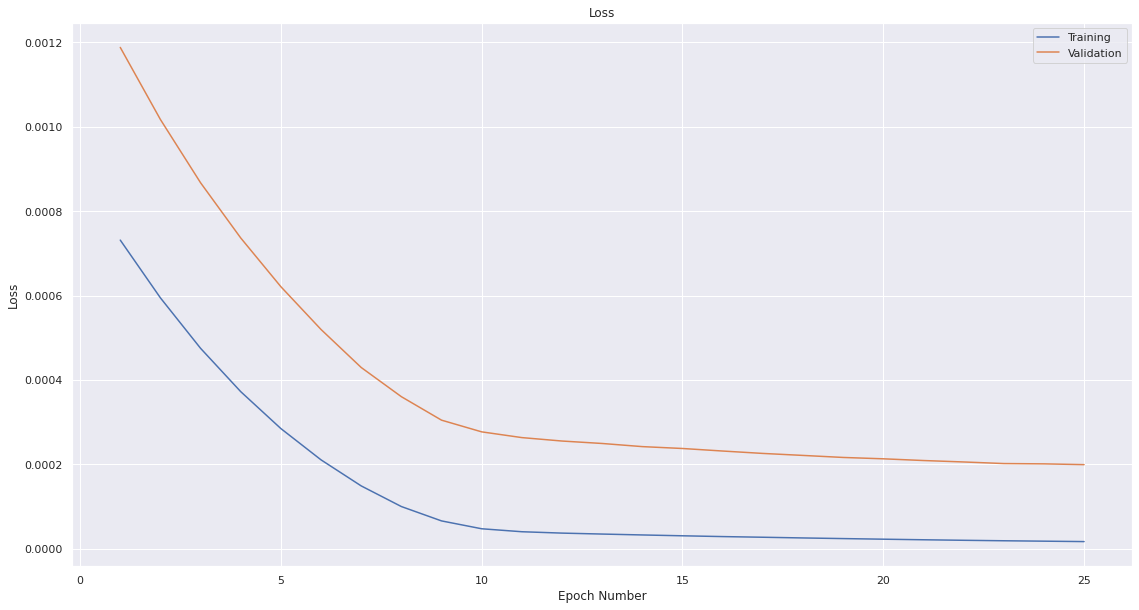

Best validation error:  25


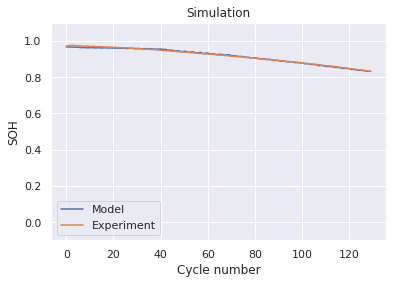

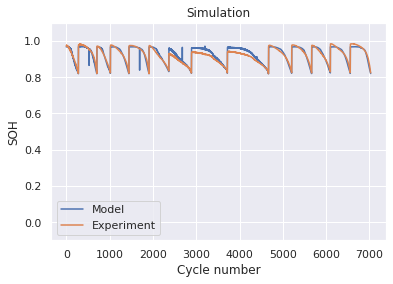

In [ ]:
# Training loop:
Nb_Epochs = 25          ###
Learning_Rate = 1e-5    ###


Train_info, _, _, date = Train(
    train_loader, valid_loader, Model, Nb_Epochs, plot_bool=True,
    LR=Learning_Rate, report=True, print_bool=True, device=device,
    remove_bool=True
    )

# updating the Model's norm attribute after training in case report=False:
Model.update_norm() 

# Best epoch's performance:
simulate(sim_train_loader, Model, denormalize=False, device=device, report=True)
simulate(valid_loader, Model, denormalize=False, device=device, report=True)

In [ ]:
# Calculating the model's error for each battery separately:
Load_Save(date, device=device, dataset_name=dataset_name, denormalize_bool=False)

if dataset_name == 'MIT':
    Load_Save_v2(date, dataset_name, device=device,
                 time_step=train_dataset.time_step, norm_test='Model',
                 cycle_lim=cycle_lim, denormalize_bool=False)

B0000
280
B0001
130
B0002
426
B0003
313
B0004
427
B0005
465
B0006
457
B0007
522
B0008
829
B0009
951
B0010
534
B0011
461
B0012
432
B0013
460
B0014
471
B0000.txt
B0001.txt (used in training)
B0002.txt
B0003.txt
B0004.txt
B0005.txt
B0006.txt
B0007.txt
B0008.txt
B0009.txt
B0010.txt
B0011.txt
B0012.txt
B0013.txt
B0014.txt
B0000.txt
B0001.txt (used in training)
B0002.txt
B0003.txt
B0004.txt
B0005.txt
B0006.txt
B0007.txt
B0008.txt
B0009.txt
B0010.txt
B0011.txt
B0012.txt
B0013.txt
B0014.txt
<class 'type'>
B0000
280
B0001
130
B0002
426
B0003
313
B0004
427
B0005
465
B0006
457
B0007
522
B0008
829
B0009
951
B0010
534
B0011
461
B0012
432
B0013
460
B0014
471
B0015
126
B0016
382
B0017
477
B0018
466
B0019
443
B0020
487
B0021
475
B0022
501
B0023
509
B0024
205
B0025
152
B0026
186
B0027
454
B0028
494
B0029
483
B0030
465
B0031
477
B0032
506
B0033
507
B0034
485
B0035
449
B0036
524
B0037
468
B0038
455
B0039
449
B0040
479
B0041
416
B0042
450
B0043
447
B0044
444
B0045
470
B0046
420
B0047
676
